# Imports

In [1]:
#Pandas, Numpy importieren
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as sl
import scipy.stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

#Importeieren der Modelle aus verschiedenen Bibliotheken
from sklearn.linear_model import LinearRegression
from statsmodels.regression.linear_model import GLS
from linearmodels.panel import PooledOLS


# Splitting data into training and testing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.model_selection import train_test_split

# No warnings about setting value on copy of slice
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 600)

# Matplotlib visualization
%matplotlib inline
# Set default font size
plt.rcParams['font.size'] = 24

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize
#figsize(6, 6)

# Seaborn for visualization
sns.set(font_scale = 2)

# Import der Daten

In [2]:
pd.set_option('display.max_columns', 600)

data = pd.read_csv('../../data/read_imputed_2.csv')
data = data.sample(frac=1)

data.info()
#data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 259 entries, 76 to 87
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   LOCATION           259 non-null    object 
 1   SUBJECT            259 non-null    object 
 2   TIME               259 non-null    float64
 3   PISA Read          259 non-null    float64
 4   GINI               259 non-null    float64
 5   STR_SRY            259 non-null    float64
 6   CPI                259 non-null    float64
 7   ALC_PC             259 non-null    float64
 8   INTERNET_PC        259 non-null    float64
 9   HOMICIDES          259 non-null    float64
 10  log(MIGRANTS)      259 non-null    float64
 11  log(GDP)           259 non-null    float64
 12  log(EDU_SPENDING)  259 non-null    float64
 13  log(PCT_EDU_TRY)   259 non-null    float64
dtypes: float64(12), object(2)
memory usage: 30.4+ KB


# Benötigte Funktionen

## Methode zur Modellierung

In [3]:
'''
Params:  
    target: Variable, die vorhergesagt werden soll
    pexog_vars: liste der exogenen Variablen Bsp.: ['GINI', "log(GDP)", "HDI", "TIME", "LOCATION"]
    pX: Datensatz, auf dem die Kreuzvalidierung durchgeführt werden soll
    
'''

def modellieren(pexog_vars, pX, target):
    exog_vars = pexog_vars
    exog = sm.add_constant(pX[exog_vars])
    # data = data.drop(columns={"LOCATION", "TIME", "SUBJECT"})

    mod = PooledOLS(target, exog)

    pooled_res = mod.fit(cov_type='clustered', clusters=pX.LOCATION)
    
    r2_adj = (1-(((1 - pooled_res.rsquared)*(target.shape[0] - 1))/(target.shape[0]-(len(pexog_vars))-1)))
    print("R^2 adj.: ", r2_adj)
    
    return pooled_res

## Kreuzvalidierung

Die Kreuzvalidierung wird durchgeführt mit einer K-Fold Kreuzvalidierung. 

In [4]:
'''
Params: 
    n_splits: Anzahl der folds 
    target
    pexog_vars: liste der exogenen Variablen Bsp.: ['GINI', "log(GDP)", "HDI", "TIME", "LOCATION"]
    pX: Datensatz, auf dem die Kreuzvalidierung durchgeführt werden soll
    
'''



def k_fold_pooledOLS(n_splits, target, pexog_vars, pX):
    
#     #
#     exog_vars = pexog_vars.append("LOCATION", "TIME")
    features = pX
    
    
    # Splitten in der Reihenfolge der Reihen im df
    kf = KFold(n_splits, shuffle=True)
    r2 = np.zeros(n_splits)
    rmse = np.zeros(n_splits)
    r2_adj = np.zeros(n_splits)
    # print(r2)
    i=0

    for train_index, val_index in kf.split(features):
    #     print("%s %s" % (train_index, test_index))
        X_train, X_validate, y_train, y_validate = features.iloc[train_index], features.iloc[val_index], target.iloc[train_index], target.iloc[val_index]
        #print(X_train)
        
#         print(X_train)
        
        r2[i], rmse[i], r2_adj[i] = prediction(pexog_vars, X_train, y_train, X_validate,  y_validate)

    #     print(r2[i])
        i = i+1

    print("--------------------------- TOTAL ---------------------------------")
    print("R^2s: ", r2)
    # calculate mean of metrics
    print("R^2 mean: ", r2.mean())
    print("R^2 std: ", r2.std())
    
    print("\nR^2 adj.: ", r2_adj)
    # calculate mean of metrics
    print("R^2 adj. mean: ", r2_adj.mean())
    print("R^2 adj. std: ", r2_adj.std())
    
    print("\nRMSEs: ", rmse)
    # calculate mean of metrics
    print("RMSE mean: ", rmse.mean())
    print("RMSE std: ", rmse.std())

## Modell Vorhersage

In [5]:
'''
Params: 
    pexog_vars: liste der exogenen Variablen Bsp.: ['GINI', "log(GDP)", "HDI", "TIME", "LOCATION"]
    pX: 
    y_test: Y Werte des Testdatensatzes
    
'''



'''
R^2 ist NICHT out of sample => es ist das R^2 für das Modell auf den Trainingsdaten
R^2 ajd. ist NICHT out of sample => es ist das R^2 adj. für das Modell auf den Trainingsdaten
RSME ist out of sample => es ist das RMSE für das Modell auf den Testdaten
'''

def prediction(pexog_vars, pX, py, pX_test, py_test):

    #pX enthält Loaction Time Subejct
    exog = sm.add_constant(pX[pexog_vars])
    
#     print(py, exog)
    mod = PooledOLS(py, exog)

    pooled_res = mod.fit(cov_type='clustered', clusters=pX.LOCATION)
    #print(mod.predict(params=pooled_res.params, exog=X_test))
    
    
    # Prediction y^= X_test * beta
    x_pred = np.array(sm.add_constant(pX_test[pexog_vars]))
    
    b_pred = np.array(pooled_res.params)[0:len(pexog_vars)+1]

    y_pred = x_pred.dot(b_pred) 
    #print(y_pred)
    #print('\n')
    
    y_test = np.array(py_test)
    #print(y_test)
#     print('\n')
    squares = (y_pred-py_test)**2
    mse = (1/y_pred.shape[0])*(np.sum(squares))
    
#     print('Anzahl exogene Variablen: ', len(pexog_vars))
#     print('Anzahl Beobachtungen: ', y_pred.shape[0])
#     print('\n')
#     r2 = 1 - RSS/TSS
#     RSS = (np.sum(squares)
    
    # r^2 adj in-sample calculation
    r2_adj = (1-(((1 - pooled_res.rsquared)*(py.shape[0] - 1))/(py.shape[0]-(len(pexog_vars))-1)))
    
    
    ### 
   
    print('\nR^2 = ', pooled_res.rsquared)
    print('R^2 adj. = ', r2_adj)
#     print("MSE = ", mse)
    print("RMSE = ", np.sqrt(mse))
    
    return pooled_res.rsquared, np.sqrt(mse), r2_adj

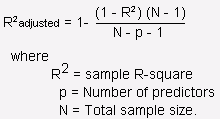

# Aufteilung der Daten in Train- & Testdatensatz

In [6]:
time = pd.Categorical(data["TIME"])
location = pd.Categorical(data["LOCATION"])
data = data.set_index(['LOCATION', 'TIME'])
data['TIME'] = time
data['LOCATION'] = location
# print(data)

features = data.drop(["PISA Read", "SUBJECT"], axis=1)
#PISA Math
X, X_test, y, y_test = train_test_split(features, data["PISA Read"], test_size = 0.1, random_state = 42)

#Festlegung der Parameter für die Modellierung methode
pX = X
target = y



# Null Modell

In [7]:
pexog_vars = []

modellieren(pexog_vars, pX, target)

R^2 adj.:  -2.220446049250313e-16


/Users/derboss/opt/anaconda3/lib/python3.8/site-packages/linearmodels/panel/data.py:98: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


Dep. Variable:,PISA Read,R-squared:,-2.22e-16
Estimator:,PooledOLS,R-squared (Between):,0.0000
No. Observations:,233,R-squared (Within):,0.0000
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.0000
Time:,11:48:10,Log-likelihood,-1159.8
Cov. Estimator:,Clustered,,
,,F-statistic:,--
Entities:,44,P-value,--
Avg Obs:,5.2955,Distribution:,--
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,--


# 1. Regressor

### CPI

In [8]:
pexog_vars = ['CPI']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.43255542598967733


Dep. Variable:,PISA Read,R-squared:,0.4350
Estimator:,PooledOLS,R-squared (Between):,0.5070
No. Observations:,233,R-squared (Within):,-0.3839
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.4350
Time:,11:48:10,Log-likelihood,-1093.3
Cov. Estimator:,Clustered,,
,,F-statistic:,177.85
Entities:,44,P-value,0.0000
Avg Obs:,5.2955,Distribution:,"F(1,231)"
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,24.526


### Gini-Koeffizient

In [9]:
pexog_vars = ['GINI']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.4222541422186853


Dep. Variable:,PISA Read,R-squared:,0.4247
Estimator:,PooledOLS,R-squared (Between):,0.5041
No. Observations:,233,R-squared (Within):,0.0525
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.4247
Time:,11:48:10,Log-likelihood,-1095.4
Cov. Estimator:,Clustered,,
,,F-statistic:,170.56
Entities:,44,P-value,0.0000
Avg Obs:,5.2955,Distribution:,"F(1,231)"
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,30.223


### BIP

In [10]:
pexog_vars = ['log(GDP)']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.42559278776112885


Dep. Variable:,PISA Read,R-squared:,0.4281
Estimator:,PooledOLS,R-squared (Between):,0.5685
No. Observations:,233,R-squared (Within):,-1.0528
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.4281
Time:,11:48:10,Log-likelihood,-1094.8
Cov. Estimator:,Clustered,,
,,F-statistic:,172.89
Entities:,44,P-value,0.0000
Avg Obs:,5.2955,Distribution:,"F(1,231)"
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,21.199


### Anteil der 25-64 jährigen mit tertiärer Bildung 

In [11]:
pexog_vars = ['log(PCT_EDU_TRY)']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.4515500411824467


Dep. Variable:,PISA Read,R-squared:,0.4539
Estimator:,PooledOLS,R-squared (Between):,0.5054
No. Observations:,233,R-squared (Within):,-0.9020
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.4539
Time:,11:48:11,Log-likelihood,-1089.4
Cov. Estimator:,Clustered,,
,,F-statistic:,192.01
Entities:,44,P-value,0.0000
Avg Obs:,5.2955,Distribution:,"F(1,231)"
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,24.807


### Migration

In [12]:
pexog_vars = ['log(MIGRANTS)']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.4366219150326629


Dep. Variable:,PISA Read,R-squared:,0.4391
Estimator:,PooledOLS,R-squared (Between):,0.5183
No. Observations:,233,R-squared (Within):,-0.1914
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.4391
Time:,11:48:11,Log-likelihood,-1092.5
Cov. Estimator:,Clustered,,
,,F-statistic:,180.80
Entities:,44,P-value,0.0000
Avg Obs:,5.2955,Distribution:,"F(1,231)"
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,21.750


### Mordrate

In [13]:
pexog_vars = ['HOMICIDES']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.30466685504705626


Dep. Variable:,PISA Read,R-squared:,0.3077
Estimator:,PooledOLS,R-squared (Between):,0.3878
No. Observations:,233,R-squared (Within):,-0.2942
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.3077
Time:,11:48:11,Log-likelihood,-1117.0
Cov. Estimator:,Clustered,,
,,F-statistic:,102.65
Entities:,44,P-value,0.0000
Avg Obs:,5.2955,Distribution:,"F(1,231)"
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,61.205


### Alkohol Konsum pro Kopf

In [14]:
pexog_vars = ['ALC_PC']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.28299792837652493


Dep. Variable:,PISA Read,R-squared:,0.2861
Estimator:,PooledOLS,R-squared (Between):,0.3842
No. Observations:,233,R-squared (Within):,-0.3162
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.2861
Time:,11:48:11,Log-likelihood,-1120.6
Cov. Estimator:,Clustered,,
,,F-statistic:,92.569
Entities:,44,P-value,0.0000
Avg Obs:,5.2955,Distribution:,"F(1,231)"
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,12.878


### Internet PC

In [15]:
pexog_vars = ['INTERNET_PC']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.2992754831261413


Dep. Variable:,PISA Read,R-squared:,0.3023
Estimator:,PooledOLS,R-squared (Between):,0.3881
No. Observations:,233,R-squared (Within):,-1.6400
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.3023
Time:,11:48:11,Log-likelihood,-1117.9
Cov. Estimator:,Clustered,,
,,F-statistic:,100.09
Entities:,44,P-value,0.0000
Avg Obs:,5.2955,Distribution:,"F(1,231)"
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,26.082


### Bildungsausgaben im Sekundär Bereich

In [16]:
pexog_vars = ['log(EDU_SPENDING)']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.33530907043103986


Dep. Variable:,PISA Read,R-squared:,0.3382
Estimator:,PooledOLS,R-squared (Between):,0.3712
No. Observations:,233,R-squared (Within):,-0.6923
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.3382
Time:,11:48:11,Log-likelihood,-1111.8
Cov. Estimator:,Clustered,,
,,F-statistic:,118.03
Entities:,44,P-value,0.0000
Avg Obs:,5.2955,Distribution:,"F(1,231)"
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,18.362


### Schüler, Lehrer Verhältnis

In [17]:
pexog_vars = ['STR_SRY']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.09939792847761197


Dep. Variable:,PISA Read,R-squared:,0.1033
Estimator:,PooledOLS,R-squared (Between):,0.1181
No. Observations:,233,R-squared (Within):,-0.0162
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.1033
Time:,11:48:12,Log-likelihood,-1147.1
Cov. Estimator:,Clustered,,
,,F-statistic:,26.605
Entities:,44,P-value,0.0000
Avg Obs:,5.2955,Distribution:,"F(1,231)"
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,5.4208


# 2. Regressor

### BIP

In [18]:
pexog_vars = ['CPI', 'log(GDP)']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.49819681376489455


Dep. Variable:,PISA Read,R-squared:,0.5025
Estimator:,PooledOLS,R-squared (Between):,0.6009
No. Observations:,233,R-squared (Within):,-0.4707
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.5025
Time:,11:48:12,Log-likelihood,-1078.5
Cov. Estimator:,Clustered,,
,,F-statistic:,116.17
Entities:,44,P-value,0.0000
Avg Obs:,5.2955,Distribution:,"F(2,230)"
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,16.371


### GINI

In [19]:
pexog_vars = ['CPI', 'GINI']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.57320224160376


Dep. Variable:,PISA Read,R-squared:,0.5769
Estimator:,PooledOLS,R-squared (Between):,0.6605
No. Observations:,233,R-squared (Within):,-0.0815
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.5769
Time:,11:48:12,Log-likelihood,-1059.6
Cov. Estimator:,Clustered,,
,,F-statistic:,156.79
Entities:,44,P-value,0.0000
Avg Obs:,5.2955,Distribution:,"F(2,230)"
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,25.160


### Anteil der 25-64 jährigen mit tertiärer Bildung

In [20]:
pexog_vars = ['CPI', 'log(PCT_EDU_TRY)']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.5538807700533267


Dep. Variable:,PISA Read,R-squared:,0.5577
Estimator:,PooledOLS,R-squared (Between):,0.6243
No. Observations:,233,R-squared (Within):,-0.5177
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.5577
Time:,11:48:12,Log-likelihood,-1064.8
Cov. Estimator:,Clustered,,
,,F-statistic:,145.02
Entities:,44,P-value,0.0000
Avg Obs:,5.2955,Distribution:,"F(2,230)"
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,22.571


### Migration

In [21]:
pexog_vars = ['CPI', 'log(MIGRANTS)']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.5317150041916106


Dep. Variable:,PISA Read,R-squared:,0.5358
Estimator:,PooledOLS,R-squared (Between):,0.6116
No. Observations:,233,R-squared (Within):,-0.1759
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.5358
Time:,11:48:12,Log-likelihood,-1070.5
Cov. Estimator:,Clustered,,
,,F-statistic:,132.71
Entities:,44,P-value,0.0000
Avg Obs:,5.2955,Distribution:,"F(2,230)"
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,24.835


### Mord Rate

In [22]:
pexog_vars = ['CPI', 'HOMICIDES']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.5030361551446312


Dep. Variable:,PISA Read,R-squared:,0.5073
Estimator:,PooledOLS,R-squared (Between):,0.5874
No. Observations:,233,R-squared (Within):,-0.3225
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.5073
Time:,11:48:12,Log-likelihood,-1077.4
Cov. Estimator:,Clustered,,
,,F-statistic:,118.42
Entities:,44,P-value,0.0000
Avg Obs:,5.2955,Distribution:,"F(2,230)"
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,30.777


### Alkohol Konsum pro Kopf

In [23]:
pexog_vars = ['CPI', 'ALC_PC']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.5596209124330955


Dep. Variable:,PISA Read,R-squared:,0.5634
Estimator:,PooledOLS,R-squared (Between):,0.6697
No. Observations:,233,R-squared (Within):,-0.4033
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.5634
Time:,11:48:13,Log-likelihood,-1063.3
Cov. Estimator:,Clustered,,
,,F-statistic:,148.41
Entities:,44,P-value,0.0000
Avg Obs:,5.2955,Distribution:,"F(2,230)"
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,24.552


### Internet PC

In [24]:
pexog_vars = ['CPI', 'INTERNET_PC']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.4821124798985179


Dep. Variable:,PISA Read,R-squared:,0.4866
Estimator:,PooledOLS,R-squared (Between):,0.5555
No. Observations:,233,R-squared (Within):,-0.5590
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.4866
Time:,11:48:13,Log-likelihood,-1082.2
Cov. Estimator:,Clustered,,
,,F-statistic:,108.99
Entities:,44,P-value,0.0000
Avg Obs:,5.2955,Distribution:,"F(2,230)"
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,18.136


### Bildungsausgaben im Sekundar Bereich

In [25]:
pexog_vars = ['CPI', 'log(EDU_SPENDING)']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.5365040175401741


Dep. Variable:,PISA Read,R-squared:,0.5405
Estimator:,PooledOLS,R-squared (Between):,0.5972
No. Observations:,233,R-squared (Within):,-0.4679
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.5405
Time:,11:48:13,Log-likelihood,-1069.3
Cov. Estimator:,Clustered,,
,,F-statistic:,135.27
Entities:,44,P-value,0.0000
Avg Obs:,5.2955,Distribution:,"F(2,230)"
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,21.577


### Schüler, Lehrer Verhältnis

In [26]:
pexog_vars = ['CPI', 'STR_SRY']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.483805595463049


Dep. Variable:,PISA Read,R-squared:,0.4883
Estimator:,PooledOLS,R-squared (Between):,0.5556
No. Observations:,233,R-squared (Within):,-0.3696
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.4883
Time:,11:48:13,Log-likelihood,-1081.8
Cov. Estimator:,Clustered,,
,,F-statistic:,109.72
Entities:,44,P-value,0.0000
Avg Obs:,5.2955,Distribution:,"F(2,230)"
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,14.111


# 3. Regressor

### BIP

In [27]:
pexog_vars = ['CPI', 'GINI', 'log(GDP)']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.591652217735668


Dep. Variable:,PISA Read,R-squared:,0.5969
Estimator:,PooledOLS,R-squared (Between):,0.6937
No. Observations:,233,R-squared (Within):,-0.1460
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.5969
Time:,11:48:14,Log-likelihood,-1054.0
Cov. Estimator:,Clustered,,
,,F-statistic:,113.05
Entities:,44,P-value,0.0000
Avg Obs:,5.2955,Distribution:,"F(3,229)"
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,20.426


### Anteil der Bevölkerung mit tertiärem Bildungsabschluss

In [28]:
pexog_vars = ['CPI','GINI', 'log(PCT_EDU_TRY)']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.6693949790281521


Dep. Variable:,PISA Read,R-squared:,0.6737
Estimator:,PooledOLS,R-squared (Between):,0.7628
No. Observations:,233,R-squared (Within):,-0.3433
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.6737
Time:,11:48:14,Log-likelihood,-1029.4
Cov. Estimator:,Clustered,,
,,F-statistic:,157.58
Entities:,44,P-value,0.0000
Avg Obs:,5.2955,Distribution:,"F(3,229)"
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,34.390


### Migration

In [29]:
pexog_vars = ['CPI', 'GINI', 'log(MIGRANTS)']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.6154154894029106


Dep. Variable:,PISA Read,R-squared:,0.6204
Estimator:,PooledOLS,R-squared (Between):,0.7083
No. Observations:,233,R-squared (Within):,-0.0255
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.6204
Time:,11:48:14,Log-likelihood,-1047.0
Cov. Estimator:,Clustered,,
,,F-statistic:,124.75
Entities:,44,P-value,0.0000
Avg Obs:,5.2955,Distribution:,"F(3,229)"
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,31.882


### Alkohol Konsum pro Kopf

In [30]:
pexog_vars = ['CPI', 'GINI', 'ALC_PC']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.6183218957300849


Dep. Variable:,PISA Read,R-squared:,0.6233
Estimator:,PooledOLS,R-squared (Between):,0.7178
No. Observations:,233,R-squared (Within):,-0.1275
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.6233
Time:,11:48:14,Log-likelihood,-1046.1
Cov. Estimator:,Clustered,,
,,F-statistic:,126.28
Entities:,44,P-value,0.0000
Avg Obs:,5.2955,Distribution:,"F(3,229)"
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,21.055


### Mordrate

In [31]:
pexog_vars = ['CPI', 'GINI', 'HOMICIDES']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.5776155046213484


Dep. Variable:,PISA Read,R-squared:,0.5831
Estimator:,PooledOLS,R-squared (Between):,0.6659
No. Observations:,233,R-squared (Within):,-0.0833
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.5831
Time:,11:48:14,Log-likelihood,-1057.9
Cov. Estimator:,Clustered,,
,,F-statistic:,106.75
Entities:,44,P-value,0.0000
Avg Obs:,5.2955,Distribution:,"F(3,229)"
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,35.101


### Internet PC

In [32]:
pexog_vars = ['CPI', 'GINI', 'INTERNET_PC']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.5896020475998514


Dep. Variable:,PISA Read,R-squared:,0.5949
Estimator:,PooledOLS,R-squared (Between):,0.6806
No. Observations:,233,R-squared (Within):,-0.1853
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.5949
Time:,11:48:14,Log-likelihood,-1054.6
Cov. Estimator:,Clustered,,
,,F-statistic:,112.10
Entities:,44,P-value,0.0000
Avg Obs:,5.2955,Distribution:,"F(3,229)"
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,20.499


### Bildungsausgaben im Sekundar Bereich

In [33]:
pexog_vars = ['GINI', 'log(PCT_EDU_TRY)', 'log(EDU_SPENDING)']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.6533919033074764


Dep. Variable:,PISA Read,R-squared:,0.6579
Estimator:,PooledOLS,R-squared (Between):,0.7449
No. Observations:,233,R-squared (Within):,-0.5447
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.6579
Time:,11:48:15,Log-likelihood,-1034.9
Cov. Estimator:,Clustered,,
,,F-statistic:,146.78
Entities:,44,P-value,0.0000
Avg Obs:,5.2955,Distribution:,"F(3,229)"
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,39.173


### Schüler, Lehrer Verhältnis

In [34]:
pexog_vars = ['GINI', 'log(PCT_EDU_TRY)', 'STR_SRY']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.6473408135305236


Dep. Variable:,PISA Read,R-squared:,0.6519
Estimator:,PooledOLS,R-squared (Between):,0.7497
No. Observations:,233,R-squared (Within):,-0.5727
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.6519
Time:,11:48:15,Log-likelihood,-1036.9
Cov. Estimator:,Clustered,,
,,F-statistic:,142.95
Entities:,44,P-value,0.0000
Avg Obs:,5.2955,Distribution:,"F(3,229)"
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,33.847


# 4. Regressor

### BIP

In [35]:
pexog_vars = ['CPI', 'GINI', 'log(PCT_EDU_TRY)', 'log(GDP)']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.6686265354264911


Dep. Variable:,PISA Read,R-squared:,0.6743
Estimator:,PooledOLS,R-squared (Between):,0.7596
No. Observations:,233,R-squared (Within):,-0.3157
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.6743
Time:,11:48:15,Log-likelihood,-1029.1
Cov. Estimator:,Clustered,,
,,F-statistic:,118.03
Entities:,44,P-value,0.0000
Avg Obs:,5.2955,Distribution:,"F(4,228)"
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,26.494


### Homicides

In [36]:
pexog_vars = ['CPI', 'GINI', 'log(PCT_EDU_TRY)', 'HOMICIDES']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.6828660809373455


Dep. Variable:,PISA Read,R-squared:,0.6883
Estimator:,PooledOLS,R-squared (Between):,0.7808
No. Observations:,233,R-squared (Within):,-0.3976
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.6883
Time:,11:48:15,Log-likelihood,-1024.0
Cov. Estimator:,Clustered,,
,,F-statistic:,125.89
Entities:,44,P-value,0.0000
Avg Obs:,5.2955,Distribution:,"F(4,228)"
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,116.31


### Migration

In [37]:
pexog_vars = ['CPI', 'GINI', 'log(PCT_EDU_TRY)', 'log(MIGRANTS)']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.6738542686157988


Dep. Variable:,PISA Read,R-squared:,0.6795
Estimator:,PooledOLS,R-squared (Between):,0.7699
No. Observations:,233,R-squared (Within):,-0.2903
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.6795
Time:,11:48:15,Log-likelihood,-1027.3
Cov. Estimator:,Clustered,,
,,F-statistic:,120.83
Entities:,44,P-value,0.0000
Avg Obs:,5.2955,Distribution:,"F(4,228)"
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,33.112


### Alkohol Konsum pro Kopf

In [38]:
pexog_vars = ['CPI', 'GINI', 'log(PCT_EDU_TRY)', 'ALC_PC']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.6954405025642838


Dep. Variable:,PISA Read,R-squared:,0.7007
Estimator:,PooledOLS,R-squared (Between):,0.7872
No. Observations:,233,R-squared (Within):,-0.2385
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.7007
Time:,11:48:15,Log-likelihood,-1019.3
Cov. Estimator:,Clustered,,
,,F-statistic:,133.44
Entities:,44,P-value,0.0000
Avg Obs:,5.2955,Distribution:,"F(4,228)"
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,30.530


### Internet PC

In [39]:
pexog_vars = ['CPI', 'GINI', 'log(PCT_EDU_TRY)', 'INTERNET_PC']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.6722982969534508


Dep. Variable:,PISA Read,R-squared:,0.6779
Estimator:,PooledOLS,R-squared (Between):,0.7639
No. Observations:,233,R-squared (Within):,-0.2668
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.6779
Time:,11:48:15,Log-likelihood,-1027.8
Cov. Estimator:,Clustered,,
,,F-statistic:,119.99
Entities:,44,P-value,0.0000
Avg Obs:,5.2955,Distribution:,"F(4,228)"
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,28.645


### Bildungsausgaben im Sekundar Bereich

In [40]:
pexog_vars = ['CPI', 'GINI', 'log(PCT_EDU_TRY)', 'log(EDU_SPENDING)']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.6801282240266937


Dep. Variable:,PISA Read,R-squared:,0.6856
Estimator:,PooledOLS,R-squared (Between):,0.7672
No. Observations:,233,R-squared (Within):,-0.3539
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.6856
Time:,11:48:16,Log-likelihood,-1025.0
Cov. Estimator:,Clustered,,
,,F-statistic:,124.32
Entities:,44,P-value,0.0000
Avg Obs:,5.2955,Distribution:,"F(4,228)"
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,28.999


### Schüler, Lehrer Verhältnis

In [41]:
pexog_vars = ['CPI', 'GINI', 'log(PCT_EDU_TRY)', 'STR_SRY']

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.6706154369987161


Dep. Variable:,PISA Read,R-squared:,0.6763
Estimator:,PooledOLS,R-squared (Between):,0.7676
No. Observations:,233,R-squared (Within):,-0.3605
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.6763
Time:,11:48:16,Log-likelihood,-1028.4
Cov. Estimator:,Clustered,,
,,F-statistic:,119.09
Entities:,44,P-value,0.0000
Avg Obs:,5.2955,Distribution:,"F(4,228)"
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,25.596


# 5. Regressor

### BIP

In [42]:
pexog_vars = ['CPI', 'GINI', 'log(PCT_EDU_TRY)', 'ALC_PC', 'log(GDP)'] 

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.6948103346496892


Dep. Variable:,PISA Read,R-squared:,0.7014
Estimator:,PooledOLS,R-squared (Between):,0.7849
No. Observations:,233,R-squared (Within):,-0.2212
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.7014
Time:,11:48:16,Log-likelihood,-1019.0
Cov. Estimator:,Clustered,,
,,F-statistic:,106.64
Entities:,44,P-value,0.0000
Avg Obs:,5.2955,Distribution:,"F(5,227)"
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,24.087


### Mordrate

In [43]:
pexog_vars = ['CPI', 'GINI', 'log(PCT_EDU_TRY)', 'ALC_PC', 'HOMICIDES'] 

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.724356508218179


Dep. Variable:,PISA Read,R-squared:,0.7303
Estimator:,PooledOLS,R-squared (Between):,0.8180
No. Observations:,233,R-squared (Within):,-0.3132
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.7303
Time:,11:48:16,Log-likelihood,-1007.2
Cov. Estimator:,Clustered,,
,,F-statistic:,122.93
Entities:,44,P-value,0.0000
Avg Obs:,5.2955,Distribution:,"F(5,227)"
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,75.465


### Migration

In [44]:
pexog_vars = ['CPI', 'GINI', 'log(PCT_EDU_TRY)', 'ALC_PC', 'log(MIGRANTS)'] 

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.6949871356532147


Dep. Variable:,PISA Read,R-squared:,0.7016
Estimator:,PooledOLS,R-squared (Between):,0.7887
No. Observations:,233,R-squared (Within):,-0.2222
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.7016
Time:,11:48:16,Log-likelihood,-1019.0
Cov. Estimator:,Clustered,,
,,F-statistic:,106.72
Entities:,44,P-value,0.0000
Avg Obs:,5.2955,Distribution:,"F(5,227)"
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,26.627


### Internet PC

In [45]:
pexog_vars = ['CPI', 'GINI', 'log(PCT_EDU_TRY)', 'ALC_PC', 'INTERNET_PC'] 

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.6945920055816031


Dep. Variable:,PISA Read,R-squared:,0.7012
Estimator:,PooledOLS,R-squared (Between):,0.7869
No. Observations:,233,R-squared (Within):,-0.2227
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.7012
Time:,11:48:16,Log-likelihood,-1019.1
Cov. Estimator:,Clustered,,
,,F-statistic:,106.53
Entities:,44,P-value,0.0000
Avg Obs:,5.2955,Distribution:,"F(5,227)"
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,25.370


### Bildungsausgaben im Sekundar Bereich

In [46]:
pexog_vars = ['CPI', 'GINI', 'log(PCT_EDU_TRY)', 'ALC_PC', 'log(EDU_SPENDING)'] 

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.6959232756635146


Dep. Variable:,PISA Read,R-squared:,0.7025
Estimator:,PooledOLS,R-squared (Between):,0.7861
No. Observations:,233,R-squared (Within):,-0.2456
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.7025
Time:,11:48:17,Log-likelihood,-1018.6
Cov. Estimator:,Clustered,,
,,F-statistic:,107.19
Entities:,44,P-value,0.0000
Avg Obs:,5.2955,Distribution:,"F(5,227)"
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,24.740


### Schüler, Lehrer Verhältnis

In [47]:
pexog_vars = ['CPI', 'GINI', 'log(PCT_EDU_TRY)', 'ALC_PC', 'STR_SRY'] 

modellieren(pexog_vars, pX, target)

R^2 adj.:  0.6998985943250091


Dep. Variable:,PISA Read,R-squared:,0.7064
Estimator:,PooledOLS,R-squared (Between):,0.7952
No. Observations:,233,R-squared (Within):,-0.2508
Date:,"Fri, Feb 05 2021",R-squared (Overall):,0.7064
Time:,11:48:17,Log-likelihood,-1017.1
Cov. Estimator:,Clustered,,
,,F-statistic:,109.21
Entities:,44,P-value,0.0000
Avg Obs:,5.2955,Distribution:,"F(5,227)"
Min Obs:,1.0000,,
Max Obs:,7.0000,F-statistic (robust):,26.308


# Validierung des Modells

In [48]:
n_splits = 4
pexog_vars = ['CPI', 'GINI', 'log(PCT_EDU_TRY)', 'ALC_PC']

k_fold_pooledOLS(n_splits, target, pexog_vars, pX)


R^2 =  0.707585513714041
R^2 adj. =  0.7006644607841959
RMSE =  20.28304037957314

R^2 =  0.7126322653152894
R^2 adj. =  0.7058706715580021
RMSE =  21.751759878103886

R^2 =  0.6630681742589384
R^2 adj. =  0.6551403665944429
RMSE =  17.32574973414315

R^2 =  0.7289810334182126
R^2 adj. =  0.7226041165574647
RMSE =  20.658371075361757
--------------------------- TOTAL ---------------------------------
R^2s:  [0.70758551 0.71263227 0.66306817 0.72898103]
R^2 mean:  0.7030667466766204
R^2 std:  0.024409805689226714

R^2 adj.:  [0.70066446 0.70587067 0.65514037 0.72260412]
R^2 adj. mean:  0.6960699038735263
R^2 adj. std:  0.02498227604246061

RMSEs:  [20.28304038 21.75175988 17.32574973 20.65837108]
RMSE mean:  20.004730266795484
RMSE std:  1.6381202628787703


# Anwendung des Modells auf die Testdaten

In [49]:
pexog_vars = ['CPI', 'GINI', 'log(PCT_EDU_TRY)', 'ALC_PC']

prediction(pexog_vars, pX, target, X_test, y_test)


R^2 =  0.7006915283821409
R^2 adj. =  0.6954405025642838
RMSE =  23.973647193625464


(0.7006915283821409, 23.973647193625464, 0.6954405025642838)